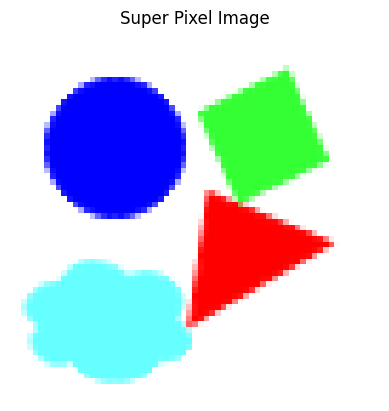

In [1]:
import cv2
import matplotlib.pyplot as plt


superPixel = cv2.imread("./superpixels.png")

plt.imshow(superPixel)
plt.title("Super Pixel Image")
plt.axis("off")
plt.show()

# a) Calculating weights through graph

In [2]:
import numpy as np
import cv2

def spatial_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def color_distance(c1, c2):
    Rc1, Gc1, Bc1 = c1
    Rc2, Gc2, Bc2 = c2
    return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)

superPixel = cv2.imread("./superpixels.png")  # Ensure path is correct
x, y, _ = superPixel.shape  # For RGB, the shape has 3 dimensions

# Parameters
sigma_color = np.std(superPixel.flatten())  #Flatten to compute overall std dev
sigma_color = 10
sigma_space = max(x, y) / 10 
sigma_space = 10
radius = 10  #Example radius

# Initialize weights
weights = np.zeros((x * y, x * y))  # i * j times distance

#Computing weights
for i in range(x):
    for j in range(y):
        idx1 = i * y + j  # Map 2D indices to 1D index
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                ni, nj = i + di, j + dj
                if 0 <= ni < x and 0 <= nj < y:  # Ensure valid indices
                    idx2 = ni * y + nj
                    # Compute distances
                    distSpace = spatial_distance((i, j), (ni, nj))
                    color1 = superPixel[i, j]
                    color2 = superPixel[ni, nj]
                    distColor = color_distance(color1, color2)
                    # Compute weight
                    weights[idx1, idx2] = np.exp(-distColor**2 / (2 * sigma_color**2)) * \
                                          np.exp(-distSpace**2 / (2 * sigma_space**2))


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)


# b) Computing the normalized cut

In [3]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh


weights = (weights + weights.T) / 2  # Ensure symmetry (still sparse)

#Degree matrix D
degree_values = np.array(weights.sum(axis=1)).flatten()

epsilon = 1e-10
degree_values[degree_values == 0] = epsilon  # Replace zeros with a small value

D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_values))  # D^{-1/2} (dense diagonal matrix)

D_inv_sqrt_sparse = csr_matrix(D_inv_sqrt)  # Convert D^{-1/2} to sparse
L_sym_sparse = csr_matrix(np.eye(weights.shape[0])) - D_inv_sqrt_sparse @ weights @ D_inv_sqrt_sparse

#first k eigenvectors
k = 5  # Number of clusters or segments
eigenvalues, eigenvectors = eigsh(L_sym_sparse, k=k, which='SM') 

print(f"First {k} eigenvalues: {eigenvalues}")


First 5 eigenvalues: [-6.11233704e-17  7.73171023e-19  4.86709229e-11  8.11703409e-08
  3.00757189e-06]


# c) K means for segments

C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


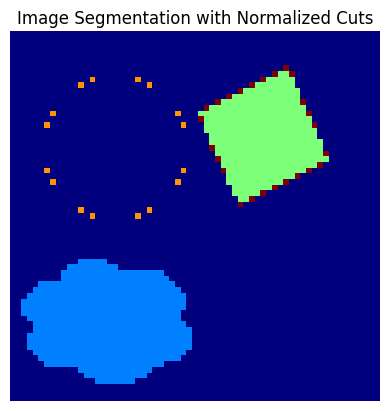

In [4]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

#Normalize eigenvector rows
U_normalized = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)

#k-means clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)  # Set n_init for stability
labels = kmeans.fit_predict(U_normalized)

segmentation = labels.reshape((x, y))

# Visualize the segmentation
plt.imshow(segmentation, cmap="jet")
plt.title("Image Segmentation with Normalized Cuts")
plt.axis("off")
plt.show()


# d) Segmentation

In [6]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define parameter ranges
sigma_color_values = [10, 20, 30]
sigma_space_values = [5, 10, 15]
radius_values = [5, 10]

# Initialize parameters to find best ones
best_segmentation = None
best_params = None
best_score = float('-inf')
results = []

def evaluate_segmentation(segmentation, ground_truth=None):
    if ground_truth is not None:
        # Example: Compute Adjusted Rand Index (requires sklearn.metrics.adjusted_rand_score)
        from sklearn.metrics import adjusted_rand_score
        return adjusted_rand_score(ground_truth.flatten(), segmentation.flatten())
    return -np.std(segmentation)  # Placeholder: Negative std deviation (higher is better)

for sigma_color in sigma_color_values:
    for sigma_space in sigma_space_values:
        for radius in radius_values:
            print(f"Testing parameters: sigma_color={sigma_color}, sigma_space={sigma_space}, radius={radius}")
            
            #Compute weights
            weights = lil_matrix((x * y, x * y))
            for i in range(x):
                for j in range(y):
                    idx1 = i * y + j
                    for di in range(-radius, radius + 1):
                        for dj in range(-radius, radius + 1):
                            ni, nj = i + di, j + dj
                            if 0 <= ni < x and 0 <= nj < y:
                                idx2 = ni * y + nj
                                distSpace = spatial_distance((i, j), (ni, nj))
                                if distSpace <= radius:  #limit distance
                                    color1 = superPixel[i, j]
                                    color2 = superPixel[ni, nj]
                                    distColor = color_distance(color1, color2)
                                    weight = np.exp(-distColor**2 / (2 * sigma_color**2)) * \
                                             np.exp(-distSpace**2 / (2 * sigma_space**2))
                                    weights[idx1, idx2] = weight
            
            weights = weights.tocsr()  # Convert to CSR for fast matrix operations

            #compute Laplacian
            degree_values = np.array(weights.sum(axis=1)).flatten()
            epsilon = 1e-10
            degree_values[degree_values == 0] = epsilon  # Avoid division by zero
            D_inv_sqrt = csr_matrix(np.diag(1.0 / np.sqrt(degree_values)))
            L_sym_sparse = csr_matrix(np.eye(weights.shape[0])) - D_inv_sqrt @ weights @ D_inv_sqrt
            
            #compute eigenvectors
            eigenvalues, eigenvectors = eigsh(L_sym_sparse, k=5, which='SM')
            U_normalized = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)
            
            #k-means clustering
            kmeans = KMeans(n_clusters=5, random_state=0)
            labels = kmeans.fit_predict(U_normalized)
            segmentation = labels.reshape((x, y))
            
            # Evaluate segmentation
            score = evaluate_segmentation(segmentation)
            results.append((sigma_color, sigma_space, radius, score))
            
            if score > best_score:  #higher score is better
                best_score = score
                best_segmentation = segmentation
                best_params = (sigma_color, sigma_space, radius)

# Output the best parameters and segmentation
print(f"Best parameters: sigma_color={best_params[0]}, sigma_space={best_params[1]}, radius={best_params[2]}")




Testing parameters: sigma_color=10, sigma_space=5, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=10, sigma_space=5, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=10, sigma_space=10, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=10, sigma_space=10, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=10, sigma_space=15, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=10, sigma_space=15, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=20, sigma_space=5, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=20, sigma_space=5, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=20, sigma_space=10, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=20, sigma_space=10, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=20, sigma_space=15, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=20, sigma_space=15, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=30, sigma_space=5, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=30, sigma_space=5, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=30, sigma_space=10, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=30, sigma_space=10, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=30, sigma_space=15, radius=5


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)
C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Testing parameters: sigma_color=30, sigma_space=15, radius=10


C:\Users\colak\AppData\Local\Temp\ipykernel_20104\1854665481.py:10: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((Rc1 - Rc2)**2 + (Gc1 - Gc2)**2 + (Bc1 - Bc2)**2)


Best parameters: sigma_color=10, sigma_space=15, radius=10


C:\Users\colak\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


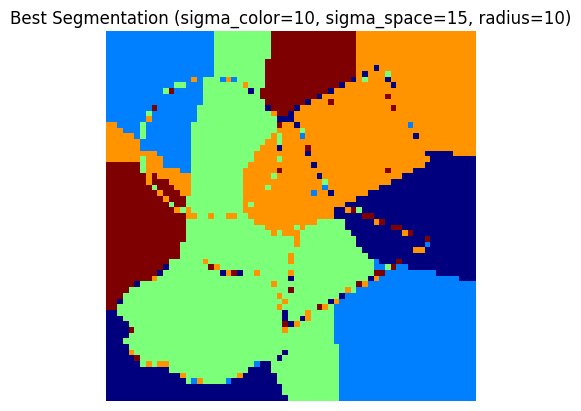

In [10]:
# Visualize the best segmentation
plt.imshow(best_segmentation, cmap="jet")
plt.title(f"Best Segmentation (sigma_color={best_params[0]}, sigma_space={best_params[1]}, radius={best_params[2]})")
plt.axis("off")
plt.show()

# Analyze results
df = pd.DataFrame(results, columns=["sigma_color", "sigma_space", "radius", "score"])

